Objective - 3

In [12]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

# Check column names before merging
print("Movies Columns:", movies.columns)
print("Credits Columns:", credits.columns)

# Ensure 'title' column exists before merging
if "title" not in movies.columns:
    raise KeyError("Column 'title' is missing from tmdb_5000_movies.csv. Please check the dataset.")

# Merge datasets correctly (keeping 'title' from movies.csv)
movies = movies.merge(credits[['movie_id']], left_on="id", right_on="movie_id", how="left")

# Verify if 'title' column exists after merging
if "title" not in movies.columns:
    raise KeyError("Column 'title' not found in merged dataset. Check the merge process.")

# Select relevant features
def clean_text(text):
    return text.lower().replace(" ", "") if isinstance(text, str) else ""

movies["cleaned_overview"] = movies["overview"].apply(clean_text)

# Convert text to numerical representation
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(movies["cleaned_overview"])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Save the model
with open("cosine_similarity_model.pkl", "wb") as model_file:
    pickle.dump((vectorizer, cosine_sim, movies), model_file)

# Function to get movie recommendations
def get_recommendations(title, movies_df, cosine_sim_matrix, top_n=10):
    if "title" not in movies_df.columns:
        return "Error: 'title' column not found in the dataset."
    
    idx = movies_df[movies_df["title"] == title].index
    if len(idx) == 0:
        return "Movie not found!"
    idx = idx[0]
    similarity_scores = list(enumerate(cosine_sim_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:top_n+1]
    movie_indices = [i[0] for i in similarity_scores]
    return movies_df["title"].iloc[movie_indices]

# Example Usage
recommended_movies = get_recommendations("The Dark Knight", movies, cosine_sim)
print(recommended_movies)

Movies Columns: Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')
Credits Columns: Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')
0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
6                                     Tangled
7                     Avengers: Age of Ultron
8      Harry Potter and the Half-Blood Prince
9          Batman v Superman: Dawn of Justice
Name: title, dtype: object


Objective - 4

In [16]:
import pickle
import pandas as pd
import ast
from sklearn.metrics import accuracy_score

# Load the saved model
with open("cosine_similarity_model.pkl", "rb") as model_file:
    vectorizer, cosine_sim, movies = pickle.load(model_file)

# Function to process genres column
def extract_genres(genre_str):
    try:
        genre_list = ast.literal_eval(genre_str)  # Convert string to list of dicts
        return [genre["name"] for genre in genre_list]
    except:
        return []

movies["processed_genres"] = movies["genres"].apply(extract_genres)

# Function to evaluate model performance using accuracy_score
def evaluate_recommendation_system():
    sample_movies = movies["title"].sample(10).values  # Select random movies for testing
    y_true = []  # Actual genres
    y_pred = []  # Predicted genres
    
    for movie in sample_movies:
        recommendations = get_recommendations(movie, movies, cosine_sim, top_n=5)
        
        if isinstance(recommendations, str):
            continue  # Skip if movie not found
        
        # Extract genres for comparison
        movie_genres = set(movies[movies["title"] == movie]["processed_genres"].values[0])
        recommended_genres = set()
        
        for rec_movie in recommendations:
            rec_movie_genres = movies[movies["title"] == rec_movie]["processed_genres"].values
            if len(rec_movie_genres) > 0:
                recommended_genres.update(rec_movie_genres[0])
        
        # Store actual and predicted values
        y_true.append(1 if movie_genres else 0)  # 1 if genres exist
        y_pred.append(1 if movie_genres & recommended_genres else 0)  # 1 if any genre matches
    
    accuracy = accuracy_score(y_true, y_pred) * 100 if y_true else 0
    print(f"Model Accuracy (based on genre similarity): {accuracy:.2f}%")

# Function to get movie recommendations
def get_recommendations(title, movies_df, cosine_sim_matrix, top_n=10):
    idx = movies_df[movies_df["title"] == title].index
    if len(idx) == 0:
        return "Movie not found!"
    idx = idx[0]
    similarity_scores = list(enumerate(cosine_sim_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:top_n+1]
    movie_indices = [i[0] for i in similarity_scores]                               
    return movies_df["title"].iloc[movie_indices]           

# Run Evaluation
evaluate_recommendation_system()


Model Accuracy (based on genre similarity): 80.00%


Objective - 5

In [17]:
import pickle
import pandas as pd
import ast
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD

# Load the saved model and dataset
with open("cosine_similarity_model.pkl", "rb") as model_file:
    vectorizer, cosine_sim, movies = pickle.load(model_file)

# Process genres for classification
def extract_genres(genre_str):
    try:
        genre_list = ast.literal_eval(genre_str)  # Convert string to list of dicts
        return [genre["name"] for genre in genre_list]
    except:
        return []

movies["processed_genres"] = movies["genres"].apply(extract_genres)

# Convert genres into a binary classification problem (e.g., Action vs. Non-Action)
movies["is_action"] = movies["processed_genres"].apply(lambda x: 1 if "Action" in x else 0)

# Extract features (TF-IDF vectors from overviews)
X = vectorizer.transform(movies["cleaned_overview"])
y = movies["is_action"]  # Target variable

# Reduce dimensionality to speed up training
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train an optimized Random Forest model
clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=3)
clf.fit(X_train, y_train)

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Save the improved model
with open("advanced_movie_classifier.pkl", "wb") as model_file:
    pickle.dump(clf, model_file)

# Print evaluation results
print(f"Cross-validation Accuracy: {cross_val_scores.mean() * 100:.2f}%")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Cross-validation Accuracy: 75.95%
Test Accuracy: 73.26%
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85       709
           1       0.14      0.00      0.01       252

    accuracy                           0.73       961
   macro avg       0.44      0.50      0.43       961
weighted avg       0.58      0.73      0.63       961



Objective - 6

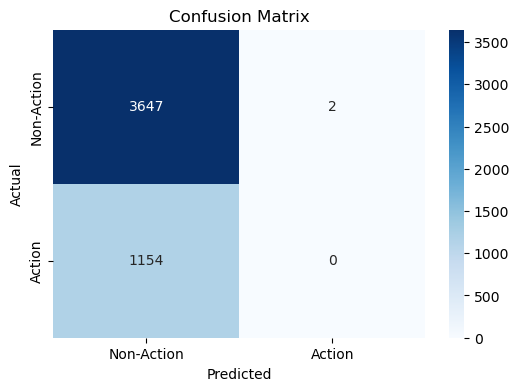

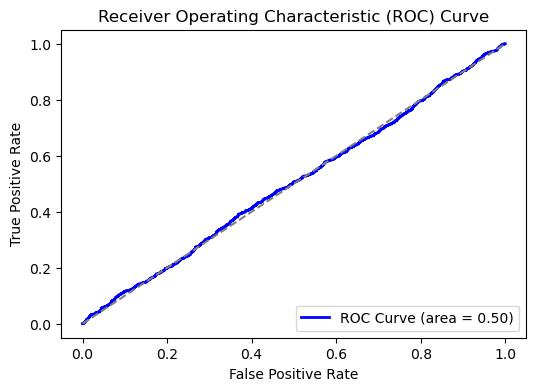

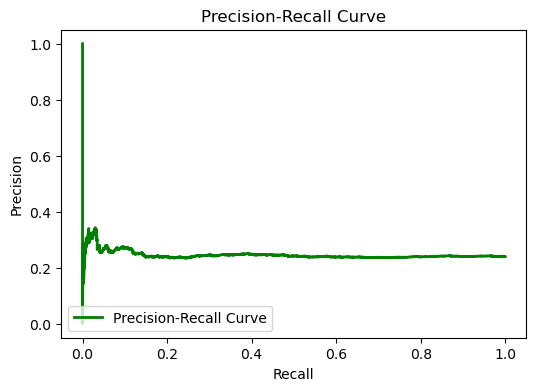

Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86      3649
           1       0.00      0.00      0.00      1154

    accuracy                           0.76      4803
   macro avg       0.38      0.50      0.43      4803
weighted avg       0.58      0.76      0.66      4803



In [18]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import pandas as pd
import ast
from sklearn.decomposition import TruncatedSVD

# Load the saved model
with open("advanced_movie_classifier.pkl", "rb") as model_file:
    clf = pickle.load(model_file)

# Load dataset and processed features
with open("cosine_similarity_model.pkl", "rb") as model_file:
    vectorizer, cosine_sim, movies = pickle.load(model_file)

# Function to process genres column
def extract_genres(genre_str):
    try:
        genre_list = ast.literal_eval(genre_str)  # Convert string to list of dicts
        return [genre["name"] for genre in genre_list]
    except:
        return []

# Recreate 'is_action' column
movies["processed_genres"] = movies["genres"].apply(extract_genres)
movies["is_action"] = movies["processed_genres"].apply(lambda x: 1 if "Action" in x else 0)

# Extract test data for visualization
X = vectorizer.transform(movies["cleaned_overview"])

# Apply the same Truncated SVD transformation (n_components=100)
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X)

y = movies["is_action"]

# Make predictions
y_pred = clf.predict(X_reduced)
y_prob = clf.predict_proba(X_reduced)[:, 1]  # Get probability scores for ROC curve

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Action", "Action"], yticklabels=["Non-Action", "Action"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# Print classification report
report = classification_report(y, y_pred)
print("Classification Report:\n", report)